# [Linear Regression] - Moneyball

In 2011, the film “Moneyball” was released. The film — adapted from the book by Micheal Lewis, is based on a true story, and follows Oakland A’s general manager Billy Beane, who, after losing his star players, must find a way to reach the playoffs whilst faced with a tight budget. Enter Paul DePodesta, an Ivy League graduate, who, using Sabermetrics, is able to identify the ‘bargain’ players in order to build the team that go on the A’s notorious 20 game win streak and see them finishing 1st in the regular season, throwing the art of sabermetrics into the limelight.

In this notebook, we will attempt to recreate pieces of DePodestas statistical analysis, using linear regression in python to model the 2002 regular season results.

The **main attributes** of the provided dataset that we need to be concerned with are:
* RS — Runs Scored
* RA — Runs Allowed
* W — Wins
* OBP — On Base Percentage
* SLG — Slugging Percentage
* BA — Batting Average
* Playoffs — Whether a team made it to playoffs or not
* OOBP — Opponent’s On Base Percentage
* OSLG — Opponents Slugging Percentage

In [84]:
#import libraries we will be using
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import *
from sklearn.linear_model import *

In [85]:
#dataframe generation
df = pd.read_csv("../input/baseball/baseball.csv")
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


Some of the attributes are self explanatory, however there are a few of them that require some explaining:
* **OBP — On Base Percentage:** This is a statistic measuring how frequently a batter reaches base, it does not take into account how far the batter runs i.e. third base.
* **SLG — Slugging Percentage:** A measure of the batting ‘Productivity’, in simple terms, it measures how far a batter makes it when they hit the ball.
* **BA — Batting Average:** Defined by the number of hits divided by at bats, measures how likely a batter is to hit a ball when pitched. Again, does not take into account how far the batter runs.

In the movie, DePodesta notices that batters are being overvalued by their BA attribute, while being completely underestimated based on their OBP and SLG attributes. Probably, this was happening as the process of recruiting was completely biased on the scout perception.

In [86]:
#RD column creation (difference between RS and RA)
df['RD'] = df['RS'] - df['RA']

#filtering data only including data from before 2002 (movie year)
df = df[df.Year < 2002]

df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


According to DePodesta, the A’s needed 99 wins in the regular season in order to make playoffs. We can create a plot to visualise this using Seaborn, which is a data visualisation library based on matplotlib.

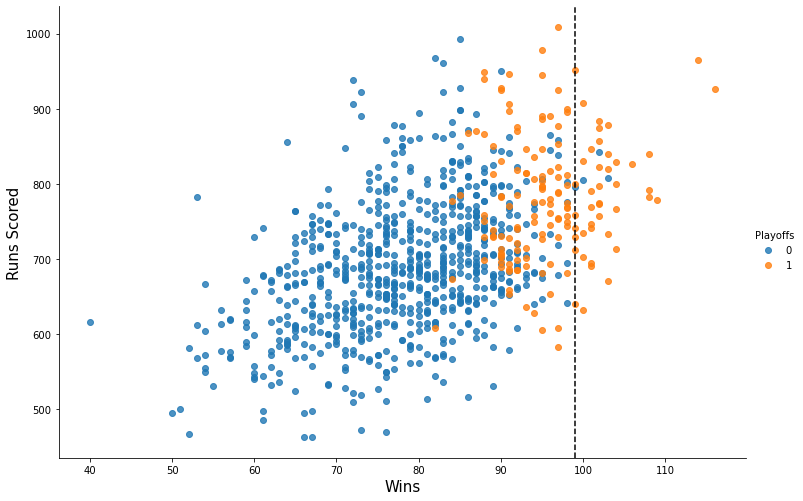

In [87]:
sns.lmplot(x = "W", y = "RS", fit_reg = False, hue = "Playoffs", data=df,height=7, aspect=1.5)
plt.xlabel("Wins", fontsize = 15)
plt.ylabel("Runs Scored", fontsize = 15)
plt.axvline(99, 0, 1, color = "Black", ls = '--')
plt.show()

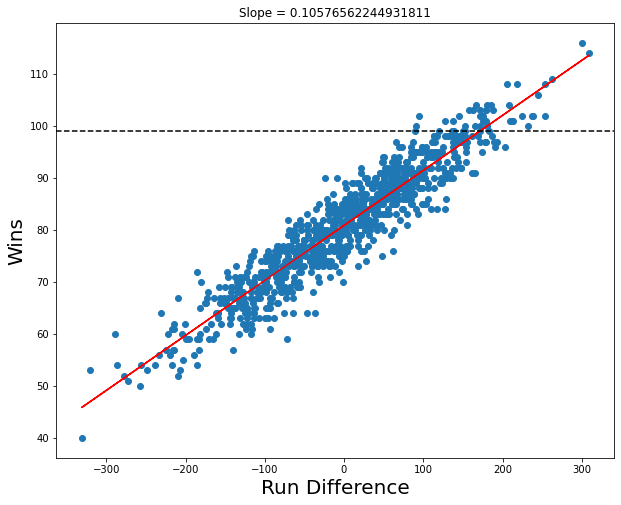

In [88]:
x = np.array(df.RD)
y = np.array(df.W)
slope, intercept = np.polyfit(x, y, 1)
abline_values = [slope * i + intercept for i in x]
plt.figure(figsize=(10,8))
plt.scatter(x, y)
plt.plot(x, abline_values, 'r')
plt.title("Slope = %s" % (slope), fontsize = 12)
plt.xlabel("Run Difference", fontsize =20)
plt.ylabel("Wins", fontsize = 20)
plt.axhline(99, 0, 1, color = "k", ls = '--')
plt.show()

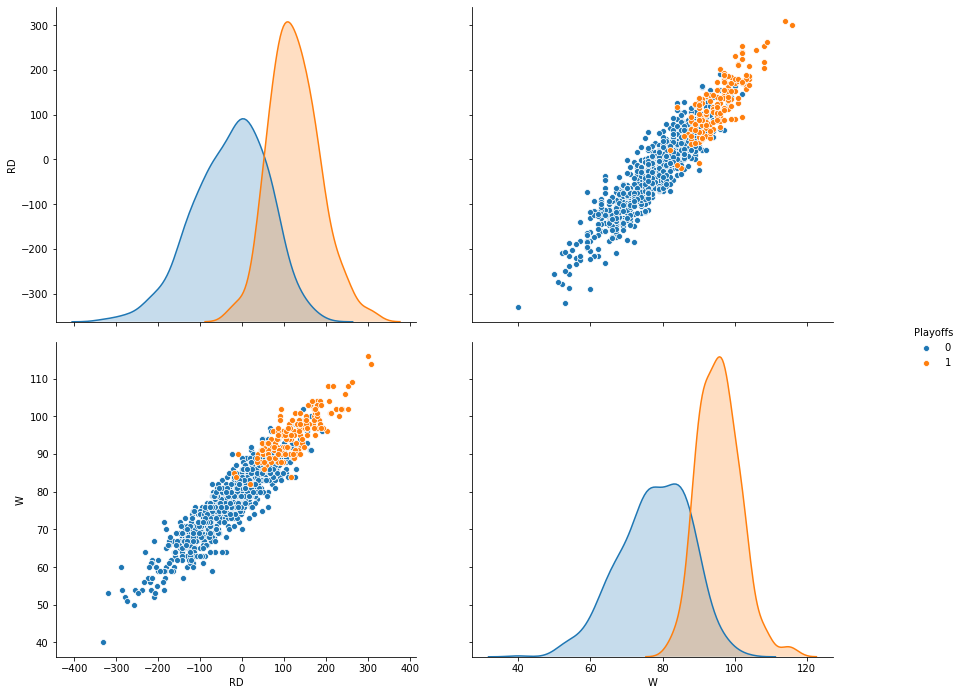

In [89]:
corrcheck = df[['RD', 'W', 'Playoffs']].copy()
g = sns.pairplot(corrcheck, hue = 'Playoffs',vars=["RD", "W"])
g.fig.set_size_inches(14,10)

In [90]:
corrcheck.corr(method='pearson')

,RD,W,Playoffs
RD,1.000000,0.938515,0.566274
W,0.938515,1.000000,0.588978
Playoffs,0.566274,0.588978,1.000000


In [91]:
podesta = df[['OBP','SLG','BA','RS']]
podesta.corr(method='pearson')

,OBP,SLG,BA,RS
OBP,1.000000,0.806154,0.854055,0.904909
SLG,0.806154,1.000000,0.814068,0.926384
BA,0.854055,0.814068,1.000000,0.831625
RS,0.904909,0.926384,0.831625,1.000000


In [92]:
#deleting NA values from dataframe
moneyball = df.dropna()

In [93]:
#we use RD as the target column
X = moneyball.iloc[:,6:9]
y = moneyball.iloc[:,-1]

#apply SelectKBest class to get best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
print('Partial results')
print(dfscores)
print(dfcolumns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print('Final results')
print(featureScores.nlargest(3,'Score'))

Partial results
          0
0  0.006262
1  0.008951
2  0.004577
     0
0  OBP
1  SLG
2   BA
Final results
  Feature     Score
1     SLG  0.008951
0     OBP  0.006262
2      BA  0.004577


[0.33089452 0.3550076  0.31409788]


Text(0, 0.5, 'Statistic')

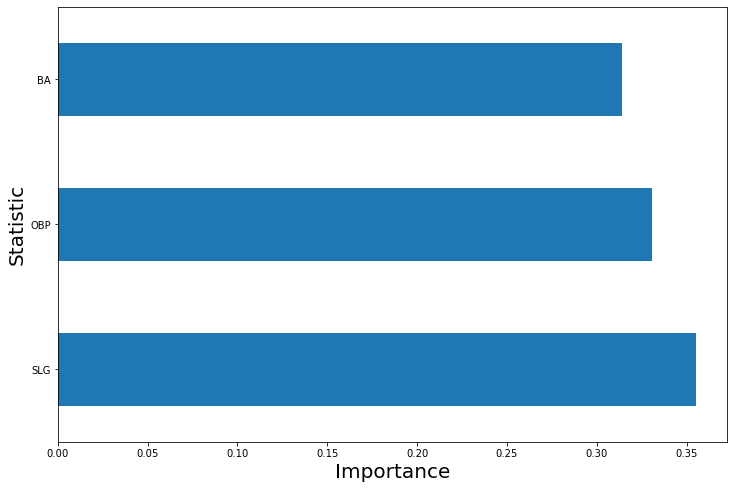

In [94]:
X = moneyball.iloc[:,6:9]  #independent columns
y = moneyball.iloc[:,-1]    #target column

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(3).plot(kind='barh', figsize = (12,8))
plt.xlabel("Importance", fontsize = 20)
plt.ylabel("Statistic", fontsize = 20)

# Model Generation

In [108]:
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


In [125]:
z = df[['OBP','SLG']].values
k = df[['RS']].values

runs_model = LinearRegression()

runs_model.fit(z,k)

print(runs_model.intercept_)
print(runs_model.coef_)

#Prediction
print('Prediction for "Runs Scored":',runs_model.predict([[0.339,0.430]]))

[-804.62706106]
[[2737.76802227 1584.90860546]]
Prediction for "Runs Scored": [[804.98699884]]


We can then say that our Runs Scored model takes the form:

RS = -804.627 + (2737.768×(OBP)) + (1584.909×(SLG))

In [126]:
t = moneyball[['OOBP','OSLG']].values
v = moneyball[['RA']].values

runs_allowed_model = LinearRegression()

runs_allowed_model.fit(t,v) 

print(runs_allowed_model.intercept_)
print(runs_allowed_model.coef_)

#Prediction
print('Prediction for "Runs Allowed":',runs_allowed_model.predict([[0.307,0.373]]))

[-775.16234861]
[[3225.00378812 1106.50390975]]
Prediction for "Runs Allowed": [[627.63977268]]


We can then say that our Runs Allowed model takes the form:

RA = -775.162 + (3225.004 ×(OOBP)) + (1106.504 ×(OSLG))

In [129]:
m = moneyball[['RD']].values
n = moneyball[['W']].values

wins_model = LinearRegression()
wins_model.fit(m,n)
 
print(wins_model.intercept_)
print(wins_model.coef_)

#Prediction
print('Prediction for "Wins":',wins_model.predict([[183]]))

[84.09190385]
[[0.08469339]]
Prediction for "Wins": [[99.59079357]]


We can say that our Wins model takes the form:

W = 84.092 + (0.085 ×(RD))